## Week 2 Day 2

Our first Agentic Framework project!!

Prepare yourself for something ridiculously easy.

We're going to build a simple Agent system for generating cold sales outreach emails:
1. Agent workflow
2. Use of tools to call functions
3. Agent collaboration via Tools and Handoffs

## Before we start - some setup:


Please visit Sendgrid at: https://sendgrid.com/

(Sendgrid is a Twilio company for sending emails.)

Please set up an account - it's free! (at least, for me, right now).

Once you've created an account, click on:

Settings (left sidebar) >> API Keys >> Create API Key (button on top right)

Copy the key to the clipboard, then add a new line to your .env file:

`SENDGRID_API_KEY=xxxx`

And also, within SendGrid, go to:

Settings (left sidebar) >> Sender Authentication >> "Verify a Single Sender"  
and verify that your own email address is a real email address, so that SendGrid can send emails for you.


In [33]:
from dotenv import load_dotenv
from agents import Agent, Runner, trace, function_tool, handoff
from openai.types.responses import ResponseTextDeltaEvent
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
import asyncio



In [21]:
load_dotenv(override=True)

True

## Step 1: Agent workflow

In [3]:
instructions1 = "You are a sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write professional, serious cold emails."

instructions2 = "You are a humorous, engaging sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write witty, engaging cold emails that are likely to get a response."

instructions3 = "You are a busy sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write concise, to the point cold emails."

In [4]:
sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini"
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini"
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini"
)

In [5]:

result = Runner.run_streamed(sales_agent1, input="Write a cold sales email") #getting back a coroutine (no await), note - using .run_streamed() not .run()

# special construct to iterate through the streamed events
async for event in result.stream_events():
    if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
        print(event.data.delta, end="", flush=True)

Subject: Simplify Your SOC 2 Compliance Journey with ComplAI

Hi [Recipient's Name],

I hope this message finds you well.

As organizations increasingly prioritize data security and compliance, navigating the complexities of SOC 2 can be daunting. At ComplAI, we understand the challenges you face in preparing for audits while ensuring ongoing compliance.

Our AI-powered SaaS tool is designed to streamline the SOC 2 compliance process, providing you with the resources needed to automate documentation, monitor ongoing compliance, and prepare for audits with confidence. With ComplAI, you can:

- Significantly reduce manual effort and save time
- Access real-time compliance insights
- Enhance your team's overall efficiency

I would love to schedule a brief call to discuss how ComplAI can specifically support [Recipient's Company Name] in meeting your compliance goals.

Thank you for considering this opportunity. I look forward to hearing from you soon.

Best regards,

[Your Name]  
[Your J

In [6]:
message = "Write a cold sales email"

with trace("Parallel cold emails"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )

outputs = [result.final_output for result in results]

for output in outputs:
    print(output + "\n\n")


Subject: Simplify Your SOC 2 Compliance Process with ComplAI

Dear [Recipient's Name],

I hope this message finds you well.

I'm [Your Name], reaching out from ComplAI, where we specialize in helping organizations like yours streamline their SOC 2 compliance and audit preparation processes through our innovative AI-powered SaaS tool.

Achieving and maintaining SOC 2 compliance can be a complex and time-consuming task. Our solution is designed to simplify this process by automating documentation, tracking compliance activities, and providing real-time insights. With ComplAI, you can focus on your core business while we handle the intricacies of compliance.

Here are a few key benefits of partnering with us:

- **Time Efficiency**: Reduce the hours spent on manual documentation and tracking.
- **Automated Alerts**: Stay ahead of potential compliance issues with proactive notifications.
- **Comprehensive Reporting**: Simplified reports to ease the audit process.

I would love the opportun

In [7]:
sales_picker = Agent(
    name="sales_picker",
    instructions="You pick the best cold sales email from the given options. \
Imagine you are a customer and pick the one you are most likely to respond to. \
Do not give an explanation; reply with the selected email only.",
    model="gpt-4o-mini"
)

In [8]:
message = "Write a cold sales email"

with trace("Selection from sales people"):
    results = await asyncio.gather(
        Runner.run(sales_agent1, message),
        Runner.run(sales_agent2, message),
        Runner.run(sales_agent3, message),
    )
    outputs = [result.final_output for result in results]

    emails = "Cold sales emails:\n\n".join(outputs)

    best = await Runner.run(sales_picker, emails)

    print(f"Best sales email:\n{best.final_output}")


Best sales email:
Subject: Ready to Make SOC2 Compliance a Walk in the Park? 🌳

Hey [Name],

I hope this email finds you well, and not buried under a mountain of compliance paperwork! If your current approach to SOC2 compliance feels like trying to find a needle in a haystack, you’re in for a treat.

At ComplAI, we’ve developed a SaaS tool that takes the guesswork out of compliance and audit preparation—think of it as your compliance fairy godmother, minus the magic wand (and sparkly dress).✨ 

Imagine an AI-powered buddy that automates documentation, streamlines processes, and even throws in a few dad jokes to keep things light. It’s like having a personal trainer for your compliance needs—minus the sweat and tears!

Curious about how we can turn your audit nightmares into sweet compliance dreams? Let’s chat! I promise to keep our conversation more exciting than your last board meeting.

Looking forward to hearing from you!

Cheerio,

[Your Name]  
[Your Position]  
ComplAI  
[Your Ph

Now go and check out the trace:

https://platform.openai.com/traces

## Part 2: use of tools

Now we will add a tool to the mix.

Remember all that json boilerplate and the `handle_tool_calls()` function with the if logic..

In [9]:
# this is just a reminder of what our agent objects look like

sales_agent1 = Agent(
        name="Professional Sales Agent",
        instructions=instructions1,
        model="gpt-4o-mini",
)

sales_agent2 = Agent(
        name="Engaging Sales Agent",
        instructions=instructions2,
        model="gpt-4o-mini",
)

sales_agent3 = Agent(
        name="Busy Sales Agent",
        instructions=instructions3,
        model="gpt-4o-mini",
)

In [10]:
sales_agent1

# if we look at one of the agent objects
# notice there is a tools param that is an empty list currently,
# and a tool_choice param

Agent(name='Professional Sales Agent', instructions='You are a sales agent working for ComplAI, a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. You write professional, serious cold emails.', handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True)

## Steps 2 and 3: Tools and Agent interactions

Remember all that boilerplate json?

Simply wrap your function with the decorator `@function_tool`

In [12]:
@function_tool
def send_email(body: str):
    """ Send out an email with the given body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("kyra.nankivell@gmail.com")  # Change to your verified sender
    to_email = To("emmaknankivell@gmail.com")  # Change to your recipient
    content = Content("text/plain", body)
    mail = Mail(from_email, to_email, "Sales email", content).get()
    response = sg.send(mail)
    return {"status": "success"}

### This has automatically been converted into a tool, with the boilerplate json created

In [13]:
# Let's look at it
send_email

FunctionTool(name='send_email', description='Send out an email with the given body to all sales prospects', params_json_schema={'properties': {'body': {'title': 'Body', 'type': 'string'}}, 'required': ['body'], 'title': 'send_email_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x1117f32e0>, strict_json_schema=True, is_enabled=True)

### And you can also convert an Agent into a tool

In [14]:
# creates a new tool with all the JSON, if tool called it calls agent who makes LLM call
tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description="Write a cold sales email")
tool1

FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x1117f2ca0>, strict_json_schema=True, is_enabled=True)

### So now we can gather all the tools together:

A tool for each of our 3 email-writing agents

And a tool for our function to send emails

In [15]:
description = "Write a cold sales email"

tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description=description)
tool2 = sales_agent2.as_tool(tool_name="sales_agent2", tool_description=description)
tool3 = sales_agent3.as_tool(tool_name="sales_agent3", tool_description=description)

tools = [tool1, tool2, tool3, send_email]

tools

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x1117f2d40>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x111768fe0>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required'

## And now it's time for our Sales Manager - our planning agent

In [22]:
instructions ="You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales_agent tools once before choosing the best one. \
You pick the single best email and use the send_email tool to send the best email (and only the best email) to the user."


sales_manager = Agent(name="Sales Manager", instructions=instructions, tools=tools, model="gpt-4o-mini")

message = "Send a cold sales email addressed to 'Dear CEO'"

with trace("Sales manager"):
    result = await Runner.run(sales_manager, message)
    print(result)

RunResult:
- Last agent: Agent(name="Sales Manager", ...)
- Final output (str):
    The cold sales email has been successfully sent to 'Dear CEO'. If you need anything else, feel free to ask!
- 9 new item(s)
- 3 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/stop.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Wait - you didn't get an email??</h2>
            <span style="color:#ff7800;">With much thanks to student Chris S. for describing his issue and fixes. 
            If you don't receive an email after running the prior cell, here are some things to check: <br/>
            First, check your Spam folder! Several students have missed that the emails arrived in Spam!<br/>Second, print(result) and see if you are receiving errors about SSL. 
            If you're receiving SSL errors, then please check out theses <a href="https://chatgpt.com/share/680620ec-3b30-8012-8c26-ca86693d0e3d">networking tips</a> and see the note in the next cell. Also look at the trace in OpenAI, and investigate on the SendGrid website, to hunt for clues. Let me know if I can help!
            </span>
        </td>
    </tr>
</table>

### And one more suggestion to send emails from student Oleksandr on Windows 11:

If you are getting certificate SSL errors, then:  
Run this in a terminal: `uv pip install --upgrade certifi`

Then run this code:
```python
import certifi
import os
os.environ['SSL_CERT_FILE'] = certifi.where()
```

Thank you Oleksandr!

## Remember to check the trace

https://platform.openai.com/traces

And then check your email!!


### **Handoffs** represent a way an agent can delegate to an agent, passing control to it

Handoffs and Agents-as-tools are similar:

In both cases, an Agent can collaborate with another Agent

With tools, control passes back

With handoffs, control passes across



In [23]:

subject_instructions = "You can write a subject for a cold sales email. \
You are given a message and you need to write a subject for an email that is likely to get a response."

html_instructions = "You can convert a text email body to an HTML email body. \
You are given a text email body which might have some markdown \
and you need to convert it to an HTML email body with simple, clear, compelling layout and design."

# agent for subject writer - use agent as tool
subject_writer = Agent(name="Email subject writer", instructions=subject_instructions, model="gpt-4o-mini")
subject_tool = subject_writer.as_tool(tool_name="subject_writer", tool_description="Write a subject for a cold sales email")

# agent for html converter - use agent as tool
html_converter = Agent(name="HTML email body converter", instructions=html_instructions, model="gpt-4o-mini")
html_tool = html_converter.as_tool(tool_name="html_converter",tool_description="Convert a text email body to an HTML email body")


In [26]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("kyra.nankivell@gmail.com")  # Change to your verified sender
    to_email = To("emmaknankivell@gmail.com")  # Change to your recipient
    content = Content("text/html", html_body) # send as HTML not text!
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.send(mail)
    return {"status": "success"}

In [27]:
tools = [subject_tool, html_tool, send_html_email]

In [28]:
tools

[FunctionTool(name='subject_writer', description='Write a subject for a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'subject_writer_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x116ae4ae0>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='html_converter', description='Convert a text email body to an HTML email body', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'html_converter_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x116ae4fe0>, strict_json_schema=True, is_enabled=True),
 FunctionTool(name='send_html_email', description='Send out an email with the given subject and HTML body to all sales pros

In [29]:
instructions ="You are an email formatter and sender. You receive the body of an email to be sent. \
You first use the subject_writer tool to write a subject for the email, then use the html_converter tool to convert the body to HTML. \
Finally, you use the send_html_email tool to send the email with the subject and HTML body."

# agent to HANDOFF to
emailer_agent = Agent(
    name="Email Manager",
    instructions=instructions,
    tools=tools,
    model="gpt-4o-mini",
    handoff_description="Convert an email to HTML and send it") # NEW! 


### Now we have 3 tools and 1 handoff

In [40]:
tools = [tool1, tool2, tool3]
handoffs = [handoff(emailer_agent)]
print(tools)
print(handoffs)

[FunctionTool(name='sales_agent1', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent1_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x1117f2d40>, strict_json_schema=True, is_enabled=True), FunctionTool(name='sales_agent2', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': ['input'], 'title': 'sales_agent2_args', 'type': 'object', 'additionalProperties': False}, on_invoke_tool=<function function_tool.<locals>._create_function_tool.<locals>._on_invoke_tool at 0x111768fe0>, strict_json_schema=True, is_enabled=True), FunctionTool(name='sales_agent3', description='Write a cold sales email', params_json_schema={'properties': {'input': {'title': 'Input', 'type': 'string'}}, 'required': 

In [41]:
sales_manager_instructions = "You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales agent tools at least once before choosing the best one. \
You can use the tools multiple times if you're not satisfied with the results from the first try. \
You select the single best email using your own judgement of which email will be most effective. \
After picking the email, you handoff to the Email Manager agent to format and send the email."


sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model="gpt-4o-mini")

message = "Send out a cold sales email addressed to Dear CEO from Alice"

with trace("Automated SDR"):
    result = await Runner.run(sales_manager, message)

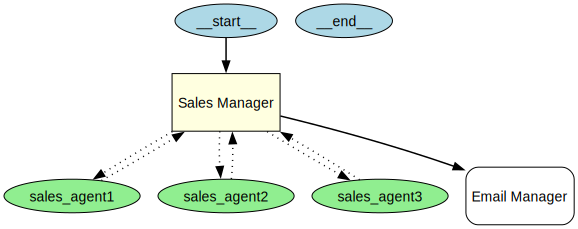

In [70]:
# Visualize the graph (see more here: https://openai.github.io/openai-agents-python/visualization)

# Prerequisites:
# - Installing the visualization extension: uv add "openai-agents[viz]"
# - Installing graphviz (if you don't have it already): 
# -- Mac: brew install graphviz

from agents.extensions.visualization import draw_graph
draw_graph(sales_manager)

### Remember to check the trace

https://platform.openai.com/traces

And then check your email!!

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">Can you identify the Agentic design patterns that were used here?<br/>
            What is the 1 line that changed this from being an Agentic "workflow" to "agent" under Anthropic's definition?<br/>
            Try adding in more tools and Agents! You could have tools that handle the mail merge to send to a list.<br/><br/>
            HARD CHALLENGE: research how you can have SendGrid call a Callback webhook when a user replies to an email,
            Then have the SDR respond to keep the conversation going! This may require some "vibe coding" 😂
            </span>
        </td>
    </tr>
</table>

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Commercial implications</h2>
            <span style="color:#00bfff;">This is immediately applicable to Sales Automation; but more generally this could be applied to  end-to-end automation of any business process through conversations and tools. Think of ways you could apply an Agent solution
            like this in your day job.
            </span>
        </td>
    </tr>
</table>

## Extra note:

Google has announced their Agent Development Kit (ADK) which is in early preview. It's still under development, so it's too early for us to cover it here. But it's interesting to note that it looks quite similar to OpenAI Agents SDK. To give you a preview, here's a peak at sample code from ADK:

```
root_agent = Agent(
    name="weather_time_agent",
    model="gemini-2.0-flash",
    description="Agent to answer questions about the time and weather in a city.",
    instruction="You are a helpful agent who can answer user questions about the time and weather in a city.",
    tools=[get_weather, get_current_time]
)
```

Well, that looks familiar!

### ChatGPT Answers to Exercises (mine are in notebook)

✅ **Agentic Design Patterns Identified:**
- **Tool abstraction**: Specific API calls wrapped as tools the agent can use.
- **Planner-executor loop**: The agent reasons about which tool to use.
- **Memory of actions**: The agent keeps state of previous outputs.
- **Autonomous operation**: Runs without user intervention once started.

✅ **Line transforming workflow → handoff:**
handoff=handoffs

It was actually in the system instructions for our SM agent "You can use the tools multiple times if you're not satisfied with the results from the first try"

In [66]:
from typing import List

@function_tool
def send_bulk_html_email(subject: str, html_body: str, recipient_emails: List[str]) -> dict:
    """
    Send an HTML email with the given subject and body to multiple recipients.
    """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    results = {}
    for email in recipient_emails:
        mail = Mail(
            from_email=Email("kyra.nankivell@gmail.com"),  # replace with your sender
            to_emails=To(email),
            subject=subject,
            html_content=Content("text/html", html_body)
        )
        try:
            response = sg.send(mail)
            results[email] = f"Sent successfully: Status {response.status_code}"
        except Exception as e:
            results[email] = f"Error: {str(e)}"
    return results

## HARD CHALLENGE: Inbound Webhook

✅ **How to enable real inbound reply handling:**
1. **Configure SendGrid Inbound Parse**:
   - In SendGrid dashboard, go to *Settings > Inbound Parse*.
   - Add a new inbound parse configuration pointing to your webhook URL (e.g., `https://yourserver.com/reply-handler`).
2. **Create an HTTP endpoint**:
   - Use Flask or FastAPI to expose `/reply-handler`.
   - Parse `request.form` or JSON body.
   - Call `handle_inbound_reply(...)` with the sender and body.
3. **Optional Auto-Reply**:
   - Inside the webhook, call `send_html_email()` to send your reply.
4. **Security**:
   - Verify SendGrid signatures to prevent spoofing.


In [67]:
# Incomplete

@function_tool
def handle_inbound_reply(sender_email: str, reply_body: str) -> dict:
    """
    Simulate processing an inbound reply. In production, you'd wire this
    to SendGrid Inbound Parse. For this exercise, we just echo the reply.
    """
    # Here you could parse, log, or trigger other workflows.
    print(f"Processing reply from {sender_email}: {reply_body}")
    
    # Simulate auto-reply content
    auto_reply_content = f"""
    <p>Hi,<br>Thank you for your reply! You wrote:<br><br>{reply_body}</p>
    """
    
    # Optionally send a reply (commented out here)
    # send_html_email(subject="Re: Your Reply", html_body=auto_reply_content)
    
    return {"status": "processed", "auto_reply_preview": auto_reply_content}

In [68]:
# Tools list: includes your existing tools plus the new ones
extended_tools = [subject_tool, html_tool, send_html_email, send_bulk_html_email, handle_inbound_reply]

enhanced_instructions = """
You are an advanced Email SDR Agent. You can:
- Write a subject line.
- Convert body text to HTML.
- Send a single email.
- Send bulk emails.
- Handle inbound replies.
Use the tools as needed to complete tasks autonomously.
"""

email_sdr_agent = Agent(
    name="Advanced Email SDR",
    instructions=enhanced_instructions,
    tools=extended_tools,
    model="gpt-4o-mini"
)

In [69]:
message = "Send out cold sales email addressed to Emma (emmaknankivell@gmail.com) and Kyra (kyra.generationai@gmail.com) from AI Agent"

with trace("Automated SDR"):
    result = await Runner.run(email_sdr_agent, message)

# it worked! just not getting through to gmail but sendgrid verified they sent the emails

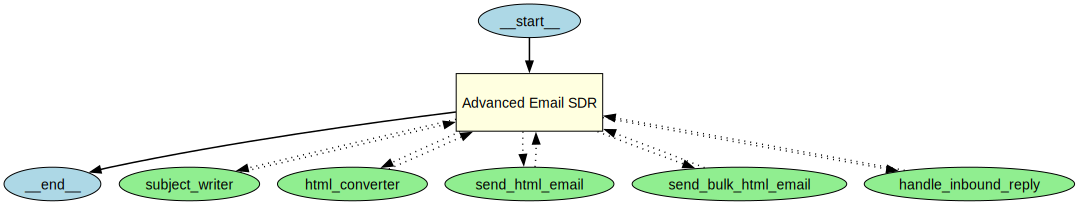

In [71]:
draw_graph(email_sdr_agent)